### Import relevant packages

In [58]:
import numpy as np
import cv2
#from utilities import *
import torchfile as tr
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
from datetime import datetime
%matplotlib inline
import math
import pandas as pd
import time
from datetime import timedelta
from skimage.transform import resize
import json
%matplotlib inline
from tqdm import tqdm

### Load training and test data

In [2]:
train_data = tr.load('../data.bin')
test_data = tr.load('../test.bin')
train_labels=tr.load('../labels.bin')

In [3]:
print("Training data shape :{}".format(train_data.shape))
print("Testing data shape :{}".format(test_data.shape))
print("Training label data shape :{}".format(train_labels.shape))

Training data shape :(29160, 108, 108)
Testing data shape :(29160, 108, 108)
Training label data shape :(29160,)


In [4]:
np.unique(train_labels,return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([4860, 4860, 4860, 4860, 4860, 4860]))

### Data Augmentation


#### Horizontal flip

In [7]:
def data_augment(image_array,image_labels):
    image_data = np.zeros((image_array.shape[0]*2,image_array.shape[1],image_array.shape[2]),dtype=np.float32)
    start_index=image_array.shape[0]
    print(start_index)
    for n,image in enumerate(image_array):
        image_data[n] = image
        image_data[start_index+n] = np.fliplr(image)
    labels = np.squeeze(np.concatenate((image_labels,image_labels)))
    return image_data,labels

In [8]:
train_data,train_labels=data_augment(train_data,train_labels)

29160


In [9]:
#train_data,train_labels=data_augment(train_data,train_labels)

In [10]:
im=train_data[11]

In [11]:
im.shape

(108, 108)

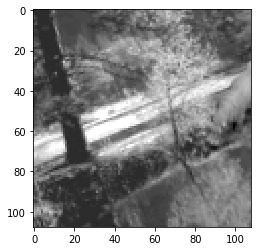

In [12]:
plt.imshow(im,cmap='gray')

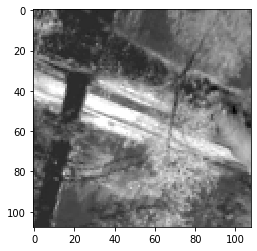

In [13]:
plt.imshow(np.flipud(im),cmap='gray')

### Split train data to train and val data

In [14]:
from sklearn.model_selection import train_test_split
test_x,valid_x,test_y,valid_y=train_test_split(train_data,train_labels,test_size=0.05,random_state=0)

### Image plot for data Visualization

In [15]:
index=15
img=train_data[index]

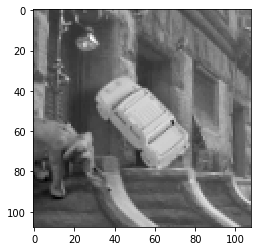

In [16]:
plt.imshow(img,cmap='gray')

### Resize images to 32*32

In [17]:
def resize_image(image_array):
    image_data = np.zeros((image_array.shape[0],64,64))
    print("as shape==",image_data.shape)
    for n,i in enumerate(image_array):
        image_data[n,:,:] = resize(image_array[n,:,:], image_data.shape[1:], anti_aliasing=True)
    return image_data

In [18]:
#data=resize_image(valid_x)
#np.save('64_64_valid_x.npy',data)

#### Load resized images

In [19]:
#test_x=np.load('64_64_test_x.npy')
#valid_x = np.load('64_64_valid_x.npy')
#test_data=np.load('64_64_test_data.npy')

### Reshaping training and test data

In [20]:
#Reshaping training data to (108*108,29160)
train_data=test_x.reshape(test_x.shape[0],-1).T
validation_data=valid_x.reshape(valid_x.shape[0],-1).T

In [21]:
#Reshaping test data to shape (108*108,29160)
test_data=test_data.reshape(test_data.shape[0],-1).T

In [22]:
#Reshaping train labels to (29160,1)
train_labels=test_y.reshape(test_y.shape[0],-1).T
validation_labels=valid_y.reshape(valid_y.shape[0],-1).T

In [23]:
train_labels_acc=np.copy(train_labels)

### Convert Lables to one hot vectors

In [24]:
train_labels=np.squeeze(np.eye(6)[train_labels]).T
#validation_labels=np.squeeze(np.eye(6)[validation_labels]).T

In [25]:
print("Training data shape after Reshape:{}".format(train_data.shape))
print("Training label data shape after Reshape:{}".format(train_labels.shape))
print("Testing data shape after Reshape:{}".format(test_data.shape))

Training data shape after Reshape:(11664, 55404)
Training label data shape after Reshape:(6, 55404)
Testing data shape after Reshape:(11664, 29160)


### Normalizing train and test data

In [26]:
train_data=255-train_data
train_data=train_data/255.0
train_data=train_data-0.5
#train_data.shape
validation_data = 255-validation_data
validation_data = validation_data/255.0
validation_data = validation_data-0.5
test_data = 255-test_data
test_data = test_data/255.0
test_data = test_data-0.5


#train_data=train_data-128
#train_data=train_data/128

#validation_data = validation_data - 128
#validation_data = validation_data/128

#test_data = test_data - 128
#test_data = test_data/128


## Defining Network Architecture

### Weight Initialization

In [27]:
def initialization(layer_dims):
    #np.random.seed(3)
    #no_of_layers = len(layer_dims)-1
    #parameters ={}
    #for l in range(1, no_of_layers + 1):
    #    parameters["W"+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1]) * np.sqrt(2./layer_dims[l-1])
        #parameters["b"+str(l)]=np.random.randn(layer_dims[l],1)
    #    parameters["b"+str(l)]=np.zeros(shape=(layer_dims[l],1))
    #parameters=np.load('parameters.npy',allow_pickle=True)
    #print('parameters==',len(parameters))
    # Load data (deserialize)
    with open('best_weights_acc_0.6546639231824417_26-11-2019_08-38-41_PM.pickle', 'rb') as handle:
        parameters = pickle.load(handle)
    #print('parameters==',len(parameters))
    return parameters

### Define Mini Batches

In [28]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, (k+1)*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, (k+1)*mini_batch_size:]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Utility Functions

In [29]:
def relu_forward(Z):
    A=np.maximum(0,Z)
    return A,Z

In [30]:
def relu_backward(prev_der,saved_data):
    this_layer_activation=saved_data  #saved_data=Z of this layer
    d_this_layer=np.array(prev_der, copy=True)
    #print("d of thsi layer===",d_this_layer)
    d_this_layer[this_layer_activation <=0 ]=0
    #print("d of thsi layer===",d_this_layer)
    return d_this_layer

In [31]:
def softmax_forward(Z):
    exp=np.exp(Z)
    sum_exp=np.sum(exp,axis=0,keepdims=True)
    softmax=exp/sum_exp
    #Z -= np.max(Z)
    #softmax = (np.exp(Z).T / np.sum(np.exp(Z),axis=1)).T
    return softmax,Z

### Forward Propogation

In [32]:
def linear_plus_activation(X,W,b,activation):
    Z = np.dot(W,X)+b

    if activation=="relu":
        A,activation_save_data=relu_forward(Z)
    else:
        A,activation_save_data=softmax_forward(Z)
    linear_save_data=(X,W,b)
    save_data=(linear_save_data,activation_save_data)
    return A,save_data

In [33]:
def forward_prop(X,parameters):    
    A=X
    cache_data=[]
    #no of layers
    L=len(parameters)//2  #W and b so //2
    for l in range(1,L):
        A_prev=A
        A ,relu_save_data= linear_plus_activation(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu")
        cache_data.append(relu_save_data)
    A_final ,softmax_save_data= linear_plus_activation(A,parameters["W"+str(L)],parameters["b"+str(L)],"softmax")
    cache_data.append(softmax_save_data)
    #print("A final : ",A_final.shape)
    return A_final,cache_data
        

In [34]:
def linear_plus_activation_dropout(X,W,b,activation,keep_prob):
    Z = np.dot(W,X)+b
    
    if activation=="relu":
        D = np.random.rand(Z.shape[0],Z.shape[1])
        D=D<keep_prob
        Z=np.multiply(Z,D)
        Z=Z/keep_prob
        A,activation_save_data=relu_forward(Z)
        linear_save_data=(X,W,b,D)
    else:
        A,activation_save_data=softmax_forward(Z)
        linear_save_data=(X,W,b)
    
    save_data=(linear_save_data,activation_save_data)
    return A,save_data

In [35]:
def forward_prop_dropout(X,parameters,keep_prob):    
    A=X
    cache_data=[]
    #no of layers
    L=len(parameters)//2  #W and b so //2
    for l in range(1,L):
        A_prev=A
        A ,relu_save_data= linear_plus_activation_dropout(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu",keep_prob)
        cache_data.append(relu_save_data)
    A_final ,softmax_save_data= linear_plus_activation_dropout(A,parameters["W"+str(L)],parameters["b"+str(L)],"softmax",keep_prob)
    cache_data.append(softmax_save_data)
    #print("A final : ",A_final.shape)
    return A_final,cache_data

### Backward propogation

#### standard backward prop

In [36]:
def backward_gradient_compute_linear(grad_from_top_layer,save_data,activation):
    linear_saved_data,activation_saved_data=save_data
    total_images=grad_from_top_layer.shape[1]
    if activation=="relu":
        grad_from_top=relu_backward(grad_from_top_layer,activation_saved_data)
    prev_activation,W,b=linear_saved_data
    #print("top grad==",grad_from_top)
    dW=np.dot(grad_from_top,prev_activation.T)/total_images
    db=np.sum(grad_from_top,axis=1,keepdims=True)/total_images
    d_pass_to_prev_layer=np.dot(W.T,grad_from_top)
    #print("dw==",dW)
    return d_pass_to_prev_layer,dW,db
    
    

In [37]:
def backward_prop(output_from_softmax,Y,saved_data):
    gradients={}
    prev_derivate=output_from_softmax-Y
    
    number_of_layers=len(saved_data)
    total_images=Y.shape[1]
    final_layer_saved=saved_data[number_of_layers-1]
    linear,activation=final_layer_saved
    gradients['dW'+str(number_of_layers)]=np.dot(prev_derivate,linear[0].T)/total_images
    gradients['db'+str(number_of_layers)]=np.sum(prev_derivate,axis=1,keepdims=True)/total_images
    prev_derivate=np.dot(linear[1].T,prev_derivate)
    for l in reversed(range(number_of_layers-1)):
        current_layer_save_data=saved_data[l]
        prev_derivate,dW,db=backward_gradient_compute_linear(prev_derivate,current_layer_save_data,"relu")
        gradients['dW'+str(l+1)]=dW
        gradients['db'+str(l+1)]=db
        #print("gradient shapes of W{0}:{1} and b{2}:{3}".format(l,dW.shape,l,db.shape))
    #print("dW1===",gradients["dW1"])
    return gradients

####  backward prop with L2 regularizer

In [38]:
def backward_gradient_compute_linear_with_regularization(grad_from_top_layer,save_data,activation,lambd):
    linear_saved_data,activation_saved_data=save_data
    total_images=grad_from_top_layer.shape[1]
    if activation=="relu":
        grad_from_top=relu_backward(grad_from_top_layer,activation_saved_data)
    prev_activation,W,b=linear_saved_data
    #print("top grad==",grad_from_top)
    dW=np.dot(grad_from_top,prev_activation.T)/total_images+lambd*W/total_images
    db=np.sum(grad_from_top,axis=1,keepdims=True)/total_images
    d_pass_to_prev_layer=np.dot(W.T,grad_from_top)
    #print("dw==",dW)
    return d_pass_to_prev_layer,dW,db

In [39]:
def backward_prop_with_regularization(output_from_softmax,Y,saved_data,lambd):
    gradients={}
    prev_derivate=output_from_softmax-Y
    
    number_of_layers=len(saved_data)
    total_images=Y.shape[1]
    final_layer_saved=saved_data[number_of_layers-1]
    linear,activation=final_layer_saved
    gradients['dW'+str(number_of_layers)]=np.dot(prev_derivate,linear[0].T)/total_images+lambd*linear[1]/total_images
    gradients['db'+str(number_of_layers)]=np.sum(prev_derivate,axis=1,keepdims=True)/total_images
    prev_derivate=np.dot(linear[1].T,prev_derivate)
    for l in reversed(range(number_of_layers-1)):
        current_layer_save_data=saved_data[l]
        prev_derivate,dW,db=backward_gradient_compute_linear_with_regularization(prev_derivate,current_layer_save_data,"relu",lambd)
        gradients['dW'+str(l+1)]=dW
        gradients['db'+str(l+1)]=db
        #print("gradient shapes of W{0}:{1} and b{2}:{3}".format(l,dW.shape,l,db.shape))
    #print("dW1===",gradients["dW1"])
    return gradients

#### backward prop with dropout

In [40]:
def backward_gradient_compute_linear_with_regularization_and_dropout(grad_from_top_layer,save_data,activation,lambd,keep_prob):
    linear_saved_data,activation_saved_data=save_data
    total_images=grad_from_top_layer.shape[1]
    if activation=="relu":
        grad_from_top=relu_backward(grad_from_top_layer,activation_saved_data)
    prev_activation,W,b,D=linear_saved_data
    #print("top grad==",grad_from_top)
    #print("D shape : ",D.shape)
    #print("grad from top shape : ",grad_from_top.shape)
    #print("prev act shape : ",prev_activation.shape)
    grad_from_top = np.multiply(grad_from_top,D)/keep_prob
    dW=np.dot(grad_from_top,prev_activation.T)/total_images+lambd*W/total_images
    db=np.sum(grad_from_top,axis=1,keepdims=True)/total_images
    #d_pass_to_prev_layer=np.multiply(np.dot(W.T,grad_from_top),D)/keep_prob: 
    d_pass_to_prev_layer=np.dot(W.T,grad_from_top)
    #print("grad pass to prev layer shape : ",d_pass_to_prev_layer.shape)
    #print("dw==",dW)
    return d_pass_to_prev_layer,dW,db

In [41]:
def backward_prop_with_regularization_and_dropout(output_from_softmax,Y,saved_data,lambd,keep_prob):
    gradients={}
    prev_derivate=output_from_softmax-Y
    
    number_of_layers=len(saved_data)
    total_images=Y.shape[1]
    final_layer_saved=saved_data[number_of_layers-1]
    linear,activation=final_layer_saved
    gradients['dW'+str(number_of_layers)]=np.dot(prev_derivate,linear[0].T)/total_images+lambd*linear[1]/total_images
    gradients['db'+str(number_of_layers)]=np.sum(prev_derivate,axis=1,keepdims=True)/total_images
    #print("shape of D : ",linear[3].shape)
    #prev_derivate=np.multiply(np.dot(linear[1].T,prev_derivate),linear[3])/keep_prob
    prev_derivate=np.dot(linear[1].T,prev_derivate)
    #print("shape of prev_: ",prev_derivate.shape)
    for l in reversed(range(number_of_layers-1)):
        current_layer_save_data=saved_data[l]
        prev_derivate,dW,db=backward_gradient_compute_linear_with_regularization_and_dropout(prev_derivate,current_layer_save_data,"relu",lambd,keep_prob)
        gradients['dW'+str(l+1)]=dW
        gradients['db'+str(l+1)]=db
        #print("gradient shapes of W{0}:{1} and b{2}:{3}".format(l,dW.shape,l,db.shape))
    #print("dW1===",gradients["dW1"])
    return gradients

### Compute Loss

In [42]:
def cost(y_hat,y):
    #print("shape of y_hat {} and y {}".format(y_hat.shape,y.shape))
    total_images=y.shape[1]
    #cost=-np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/total_images
    L_sum = np.sum(np.multiply(y, np.log(y_hat)))
    L = -(1./total_images) * L_sum

    L = np.squeeze(L) 
    return L

In [43]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(y_hat, y, parameters, lambd):
    total_images = y.shape[1]
    number_of_layers = len(parameters)//2
        
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    W4 = parameters["W4"]
    W5 = parameters["W5"]
    W6 = parameters["W6"]
    
    cross_entropy_cost = cost(y_hat, y) # This gives you the cross-entropy part of the cost
    
    ### START CODE HERE ### (approx. 1 line)
    L2_regularization_cost = lambd * (np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3))+np.sum(np.square(W4))+np.sum(np.square(W5))+np.sum(np.square(W6)))/(2*total_images)
    #L2_regularization_cost = lambd * (np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))/(2*total_images)
    ### END CODER HERE ###
    
    total_cost = cross_entropy_cost + L2_regularization_cost
    
    return total_cost

### Update parameters with gradient descent

In [44]:
def update(parameters,gradients,learning_rate):
    number_of_layers=len(parameters)//2  # sice W and B in 1 params so /2
    #print("prev weight ",parameters["W1"])
    #print("prev grad ",gradients["dW1"])
    for l in range(number_of_layers):
        parameters["W"+str(l+1)]-=learning_rate*gradients["dW"+str(l+1)]
        parameters["b"+str(l+1)]-=learning_rate*gradients["db"+str(l+1)]
    #print("new weight ",parameters["W1"])
    return parameters

### Update parameters with gradient descent with momentum

In [45]:
def initialize_adam(parameters) :
    
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    for l in range(L):
    
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    
    return v, s

In [46]:
def update_with_adam(parameters,gradients,learning_rate,beta,beta2,t,v,s):
    number_of_layers=len(parameters)//2  # sice W and B in 1 params so /2
    
    epsilon=1e-8
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}
    for l in range(number_of_layers):
        # compute velocities
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)] + (1-beta)*gradients['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)] + (1-beta)*gradients['db' + str(l+1)]
        
        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-(beta**t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-(beta**t))
        ### END CODE HERE ###
        
        # Moving average of the squared gradients. 
        
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1-beta2)*(gradients["dW" + str(l+1)]**2)
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1-beta2)*(gradients["db" + str(l+1)]**2)
        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-(beta2**t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-(beta2**t))
        ### END CODE HERE ###
        
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v_corrected["dW" + str(l+1)]\
                                                                    /(s_corrected["dW" + str(l+1)]**0.5+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected["db" + str(l+1)]\
                                                                    /(s_corrected["db" + str(l+1)]**0.5+epsilon)
    #print("new weight ",parameters["W1"])
    return parameters

In [47]:
def update_with_momentum(parameters,gradients,learning_rate,beta):
    number_of_layers=len(parameters)//2  # sice W and B in 1 params so /2
    #print("prev weight ",parameters["W1"])
    #print("prev grad ",gradients["dW1"])
    # Initialize velocity
    v={}
    s={}
    epsilon=1e-8
    for l in range(number_of_layers):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        
    for l in range(number_of_layers):
        # compute velocities
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)] + (1-beta)*gradients['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)] + (1-beta)*gradients['db' + str(l+1)]
        
        
        
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v["dW" + str(l+1)]
                                                                    
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v["db" + str(l+1)]
                                                                    
    #print("new weight ",parameters["W1"])
    return parameters

### Define complete Pipeline

In [69]:
### CONSTANTS ###
#layers_dims = [11664,120,120, 6] #  3-layer model
#layers_dims = [11664,32,10, 6] #  3-layer model
#layers_dims = [11664,10,6]
#layers_dims = [11664,150,60,32,10, 6]
layers_dims = [11664,300,150,60,32,10, 6]
#layers_dims = [4096,32,10, 6] #  3-layer model
#layers_dims = [4096,150,60,32,10, 6]
#layers_dims = [1024,32,10, 6] #  3-layer model
learning_rate = 1e-5
num_iterations = 2
L2_regularizer_lambd=5e-05
momentum_beta=0.9
momentum_beta2=0.999
mini_batch_size=512
learning_rate_decay = 0.0005 #0.005
keep_prob = 0.9

In [70]:
def create_param_dict(layers_dims,learning_rate,num_iterations,L2_regularizer_lambd,momentum_beta,momentum_beta2,mini_batch_size,learning_rate_decay,keep_prob):
    param_dict={}
    param_dict['layers_dims']=layers_dims
    param_dict['learning_rate']=learning_rate
    param_dict['num_iterations']=num_iterations
    param_dict['L2_regularizer_lambd']=L2_regularizer_lambd
    param_dict['momentum_beta']=momentum_beta
    param_dict['momentum_beta2']=momentum_beta2
    param_dict['mini_batch_size']=mini_batch_size
    param_dict['learning_rate_decay']=learning_rate_decay
    param_dict['keep_prob']=keep_prob
    return param_dict
    
    

In [50]:
def store_params(param_dict,accuracy):
    filename ='best_params_acc_'+str(accuracy)
    with open(filename +'.json'.format(accuracy), 'w') as fp:
        json.dump(param_dict, fp)
    return filename+'.json'

In [67]:
def model(X,Y,layer_dims,learning_rate , num_iterations,learning_rate_decay):
    costs = []
    mean_train_accuracy=[]
    mean_valid_accuracy = []
    mean_cost = []
    seed = 0
    t = 0 
    parameters=initialization(layer_dims)
    v,s = initialize_adam(parameters)
    iterations_per_epoch = max(X.shape[1] / mini_batch_size, 1)
    #print("para   ",parameters)
    for i in tqdm(range(0,num_iterations)):
        #start_time = time.time()
        seed = seed + 1
        train_accuracy=[]
        valid_accuracy = []
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        for indx,minibatch in enumerate(minibatches):
            
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            #forward propogation
            #y_hat,cache_data = forward_prop(minibatch_X,parameters)
            y_hat,cache_data = forward_prop_dropout(minibatch_X,parameters,keep_prob)
            #iter_cost=cost(y_hat,minibatch_Y) #non-regularized cost
            #print("y_hat :",y_hat[:,0])
            #print("y :",minibatch_Y[:,0])
            iter_cost = compute_cost_with_regularization(y_hat,minibatch_Y,parameters,L2_regularizer_lambd)
            #gradients=backward_prop(y_hat,minibatch_Y,cache_data)
            gradients = backward_prop_with_regularization_and_dropout(y_hat,minibatch_Y,cache_data,L2_regularizer_lambd,keep_prob)
            #gradients = backward_prop_with_regularization(y_hat,minibatch_Y,cache_data,L2_regularizer_lambd)
            t=t+1
            parameters=update_with_adam(parameters,gradients,learning_rate,momentum_beta,momentum_beta2,t,v,s)
            #parameters=update(parameters,gradients,learning_rate)
            if indx % 100 == 0:
                train_acc = accuracy(y_hat,minibatch_Y)
                valid_acc = predict(validation_data,validation_labels,parameters)
                #print("train acc:",train_acc)
                train_accuracy.append(train_acc)
                valid_accuracy.append(valid_acc)
                #print("Cost after epoch {0} and batch : {1}: {2}".format(i+1,indx+1, np.squeeze(iter_cost)))
                costs.append(iter_cost)
                
        #elapsed_time_secs = time.time() - start_time
        
            
        mean_cost.append(np.mean(np.squeeze(costs)))
        mean_train_accuracy.append(np.mean(np.squeeze(train_accuracy)))
        mean_valid_accuracy.append(np.mean(np.squeeze(valid_accuracy)))
        print("Train accuracy after epoch {} : {}".format(i+1,np.mean(train_accuracy)))
        print("Validation accuracy after epoch {} : {}".format(i+1,np.mean(valid_accuracy)))
        print("Mean Cost over all batches after epoch {0} : {1} \n".format(i+1,np.mean(np.squeeze(costs))))
        if np.mean(valid_accuracy) >0.67:
            best_params=create_param_dict(layers_dims,learning_rate,num_iterations,L2_regularizer_lambd,momentum_beta,momentum_beta2,mini_batch_size,learning_rate_decay,keep_prob)
            file = store_params(best_params,np.mean(valid_accuracy))
            print("Best Parameters saved in file {}".format(file))
            
            time = datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")
            with open('best_weights_acc_{0}_{1}.pickle'.format(np.mean(valid_accuracy),time), 'wb') as handle:
                pickle.dump(parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
                print("Best weights saved ")
        #print("Time for epoch {0}: {1}".format(i+1,timedelta(seconds=round(elapsed_time_secs))))
    # Decay learning rate
    
        learning_rate = learning_rate * (1/1+learning_rate_decay*i)

        print("\nreduced learning rate to : {}\n".format(learning_rate))
        print("\n-------------------------------------\n")

    
    return parameters,mean_cost,mean_train_accuracy,mean_valid_accuracy

In [61]:
def model_old(X,Y,layer_dims,learning_rate , num_iterations):
    costs = [] 
    seed = 0
    parameters=initialization(layer_dims)
    #print("para   ",parameters)
    for i in range(0,num_iterations):
        
        y_hat,cache_data = forward_prop(X,parameters)
        #iter_cost=cost(y_hat,minibatch_Y) #non-regularized cost
        iter_cost = compute_cost_with_regularization(y_hat,Y,parameters,L2_regularizer_lambd)

        if i % 1 == 0:
            print("\n Cost after iteration {}: {} \n".format(i+1, np.squeeze(iter_cost)))
            costs.append(iter_cost)

        #gradients=backward_prop(y_hat,minibatch_Y,cache_data)
        gradients = backward_prop_with_regularization(y_hat,Y,cache_data,L2_regularizer_lambd)
        parameters=update(parameters,gradients,learning_rate)

        
        if i%1000==0:
            time = datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")
            with open('parameters_{0}.pickle'.format(time), 'wb') as handle:
                pickle.dump(parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return parameters,costs

### Plot cost for Visualization

In [62]:
def plot_cost(costs,train_acc,valid_acc):
    # plot the cost
    fig = plt.figure()
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundred)')
    plt.title("Learning rate =" + str(learning_rate))
    #plt.show()
    plt.savefig('cost_2.png')

In [63]:
def plot(costs,train_acc,valid_acc):
    # plotting the cost and accuracies
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(15)
    ax1.plot(np.squeeze(costs))
    ax2.plot(np.squeeze(train_acc))
    ax3.plot(np.squeeze(valid_acc))
    
    ax1.set_ylabel('cost')
    ax1.set_xlabel('Mini batch iterations (per hundred)')
    ax1.set_title("Learning rate =" + str(learning_rate))
    ax2.set_ylabel('Train accuracy')
    ax2.set_xlabel('Mini batch iterations (per hundred)')
    ax2.set_title("Learning rate =" + str(learning_rate))
    ax3.set_ylabel('Validation accuracy')
    ax3.set_xlabel('Mini batch iterations (per hundred)')
    ax3.set_title("Learning rate =" + str(learning_rate))
    

### Model Prediction

In [64]:
def predict(X, y, parameters):
    
    total_images = y.shape[1]
    p = np.zeros((1,total_images), dtype = np.int)
    
    # Forward propagation
    y_hat,cache_data = forward_prop_dropout(X,parameters,keep_prob=1.0)
    
    prediction=np.argmax(y_hat,axis=0)
    prediction=np.squeeze(prediction.reshape(y_hat.shape[1],1))
    actual_label=np.squeeze(y)
    accuracy = sum(prediction == actual_label)/(float(len(actual_label)))
    
    return accuracy

#### Find accuracy

In [65]:
def accuracy(y_hat, y):
    
    total_images = y.shape[1]
    p = np.zeros((1,total_images), dtype = np.int)
    
    
    prediction=np.argmax(y_hat,axis=0)
    prediction=np.squeeze(prediction.reshape(y_hat.shape[1],1))
    reference=np.argmax(y,axis=0)
    reference=np.squeeze(reference.reshape(y.shape[1],1))
    
    
    accuracy = sum(prediction == reference)/(float(len(reference)))
    return accuracy

### Train Model





  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:31<00:31, 31.53s/it]

Train accuracy after epoch 1 : 0.8720703125
Validation accuracy after epoch 1 : 0.6584362139917695
Mean Cost over all batches after epoch 1 : 0.35429150030488243 


reduced learning rate to : 1e-05


-------------------------------------







100%|██████████| 2/2 [01:10<00:00, 35.30s/it]

Train accuracy after epoch 2 : 0.861328125
Validation accuracy after epoch 2 : 0.6584362139917695
Mean Cost over all batches after epoch 2 : 0.3611693178575879 


reduced learning rate to : 1.0005e-05


-------------------------------------



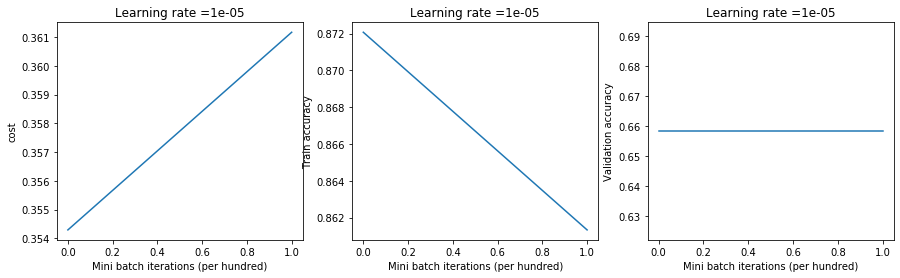

In [71]:
paramerters,costs , train_acc, validation_acc= model(train_data,train_labels,layers_dims,learning_rate,num_iterations,learning_rate_decay)
#plot cost
plot(costs,train_acc,validation_acc)

In [63]:
with open('best_weights_6layer_1.pickle','wb') as handle:
        pickle.dump(paramerters, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Best weights saved ")

Best weights saved 


### Model Accuracy

In [63]:
# Train accuracy
train_accuracy=predict(train_data,train_labels_acc,paramerters)
print("Overall Train accuracy : ",train_accuracy )

Overall Train accuracy :  0.9190130676485452


In [64]:
# Validation accuracy
Validation_accuracy=predict(validation_data,validation_labels,paramerters)
print("Overall Validation accuracy : ",Validation_accuracy )

Overall Validation accuracy :  0.6522633744855967


### Create CSV for kaggle upload

In [66]:
def convert_submission_csv(X,parameters):
    # Forward propagation
    y_hat,cache_data = forward_prop_dropout(X,parameters,keep_prob=1.0)
    
    prediction=np.argmax(y_hat,axis=0)
    prediction=np.squeeze(prediction.reshape(y_hat.shape[1],1))
    df = pd.DataFrame(data=prediction,columns=["label"])
    df = df.rename_axis('id').reset_index()
    return df
    

In [67]:
df = convert_submission_csv(test_data,paramerters)
df.to_csv('submission_with_val_65.5.csv',index=False)